# Initializing Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import timeit
import warnings

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, LearningCurveDisplay, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler , OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.feature_variance import VarianceThreshold

from sklearn.model_selection import ValidationCurveDisplay

from scipy.stats import skew

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

import itertools
import timeit

from sklearn.metrics.pairwise import pairwise_distances

#Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, f1_score, homogeneity_score
from sklearn.mixture import GaussianMixture as EM

from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA

In [3]:
from ucimlrepo import fetch_ucirepo 

In [4]:
def gtid():
    return  903952938

# Loading and Analysing Dataset

## Dataset 1 - Diabetes Prediction

In [21]:
def load_dataset_1(test_size=0.3, random_state=gtid()):
        cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
        X = cdc_diabetes_health_indicators.data.features
        y = cdc_diabetes_health_indicators.data.targets
        temp  = X.copy()
        temp['Diabetes'] = y
        temp.drop_duplicates(inplace = True)
        X,y = temp[[i for i in temp.columns if i!='Diabetes']], temp[['Diabetes']]
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test

In [22]:
X_train, X_test, y_train, y_test = load_dataset_1()

In [23]:
# Get unique values for each column
unique_values = {col: X_train[col].unique() for col in X_train.columns}

# Display unique values
for col, values in unique_values.items():
    print(f"Unique values in column '{col}': {values}")

Unique values in column 'HighBP': [1 0]
Unique values in column 'HighChol': [0 1]
Unique values in column 'CholCheck': [1 0]
Unique values in column 'BMI': [31 21 34 27 25 24 40 20 38 29 36 32 26 18 22 23 28 30 37 39 19 35 48 60
 49 33 51 44 45 42 43 47 56 14 15 54 13 87 41 50 63 46 16 17 53 57 92 55
 72 69 84 75 71 67 52 68 81 77 79 62 64 58 82 12 89 61 65 80 73 95 70 59
 66 98 74 85 90 76 88 83]
Unique values in column 'Smoker': [0 1]
Unique values in column 'Stroke': [0 1]
Unique values in column 'HeartDiseaseorAttack': [0 1]
Unique values in column 'PhysActivity': [0 1]
Unique values in column 'Fruits': [0 1]
Unique values in column 'Veggies': [0 1]
Unique values in column 'HvyAlcoholConsump': [0 1]
Unique values in column 'AnyHealthcare': [1 0]
Unique values in column 'NoDocbcCost': [0 1]
Unique values in column 'GenHlth': [3 1 2 5 4]
Unique values in column 'MentHlth': [ 0  2 30  1 15  3  5 10 20 26  4  7  8 25 14 28 12  6 21 27 22 16 29  9
 18 19 17 23 24 11 13]
Unique values in

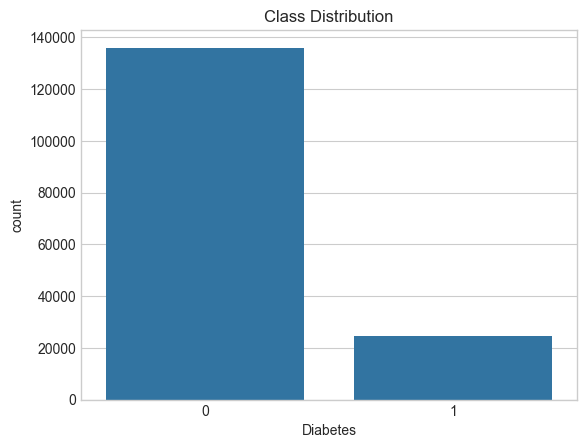

In [41]:
sns.countplot(x=y_train.Diabetes)
plt.title('Class Distribution')
plt.show()

In [24]:
X_train.shape, X_test.shape

((160631, 21), (68843, 21))

~This Dataset contains 21 attributes, 2 decision classes, 160K training samples and 68K test samples.
> HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, DiffWalk, Sex: These features (14) are binary, indicating presence (1) or absence (0) of a condition or behavior.

> GenHlth, Education, Income, Age: These features (4) have multiple distinct values

> BMI, MentHlth, PhysHlth: These (3) are High Cardinality features


~ k-means assumes that clusters are spherical and equally sized, which might not always be the case.

    - Since k-means relies on distance measures, binary features might not be well-suited unless properly preprocessed (e.g., using one-hot encoding or calculating the appropriate distance metric like Hamming distance).
    
    - Cluster : Diabetes=0 is much larger than Diabetes=1, k-means might poorly partition the data.

    -  EM can handle binary features if they are considered as Bernoulli distributions.

Althought its a binary classification problem, it will be interesting to see if clusters find more classes - risk to diabetes 


1. PCA

    Output: PCA transforms the data into a new space defined by the principal components, capturing the most variance in the data.
    
    Mitigation: Normalize the data to ensure each feature contributes equally to the variance calculation.

2. ICA

    Output: ICA identifies components that maximize statistical independence.   
    
    Mitigation: Center and whiten the data to make it more suitable for ICA.

3. Randomized Projections (RP):

    Output: RP reduces the dimensionality of the data, often with lower computational cost than PCA.
    
    Mitigation: Run multiple projections to ensure stability and robustness of the results.

Class Balancing: https://www.linkedin.com/pulse/addressing-class-imbalance-health-data-using-python-salam-sukurat-/

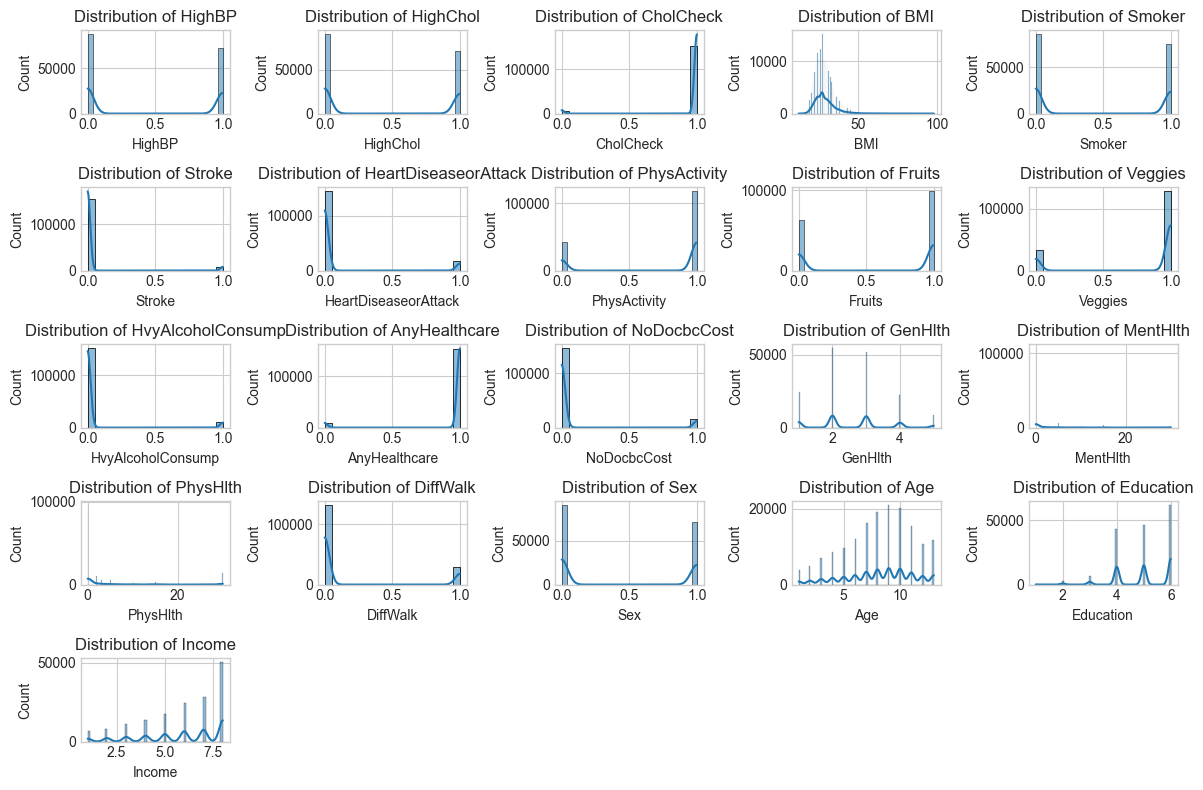

In [43]:
# Visualizing distributions
plt.figure(figsize=(12, 8))
for i, column in enumerate(X_train.columns, 1):
    plt.subplot(5, 5, i)
    sns.histplot(X_train[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

In [44]:
def identify_outliers(df):
    """
    Identifies features with outliers in a DataFrame using the IQR method.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    
    Returns:
    list: A list of features that contain outliers.
    """
    outliers_features = []
    
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.1)
        Q3 = df[column].quantile(0.9)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        if ((df[column] < lower_bound) | (df[column] > upper_bound)).any():
            outliers_features.append(column)
    
    return outliers_features

# Example usage:
# df = pd.read_csv('your_dataset.csv')
outlier_features = identify_outliers(X_train)
print("Features with outliers:", outlier_features)


Features with outliers: ['CholCheck', 'BMI', 'Stroke', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost']
